In [357]:
import lightgbm
import pandas as pd

In [358]:
data = pd.read_csv("../../Data/LWB_Monthly_data.csv")


In [359]:
init_record = data

In [360]:
init_record['_key_occurreddate_month']=init_record['_key_occurreddate_month'].astype("datetime64[ns]")
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

In [361]:
#init_record["Incident"] = init_record["response_variable"].values

In [362]:
print(init_record.shape)
init_record

(123311, 339)


incident_catgry_care_concern_piv  \
_key_client_id                       _key_occurreddate_month                                     
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                              0   
                                     2019-05-01                                              0   
                                     2019-06-01                                              0   
                                     2019-07-01                                              0   
                                     2019-08-01                                              0   
...                                                                                        ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                              0   
                                     2019-10-01                                              0   
                                     2019-11-01                                              0   
                                     2019-12-01                                              0   
                                     2020-01-01                                              0   

                                                              incident_catgry_medication_piv  \
_key_client_id                       _key_occurreddate_month                                   
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                            0   
                                     2019-05-01                                            0   
                                     2019-06-01                                            0   
                                     2019-07-01                                            0   
                                     2019-08-01                                            0   
...                                                                                      ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                            0   
                                     2019-10-01                                            0   
                                     2019-11-01                                            0   
                                     2019-12-01                                            0   
                                     2020-01-01                                            0   

                                                              incident_catgry_medical_piv  \
_key_client_id                       _key_occurreddate_month                                
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                         0   
                                     2019-05-01                                         0   
                                     2019-06-01                                         0   
                                     2019-07-01                                         0   
                                     2019-08-01                                         0   
...                                                                                   ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                         0   
                                     2019-10-01                                         0   
                                     2019-11-01                                         0   
                                     2019-12-01                                         0   
                                     2020-01-01                                         0   

                                                              incident_catgry__piv  \
_key_client_id                       _key_occurreddate_month                         
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0   
                                     2019-05-01                       

## Split Dataset to three part: Training, evaluation and testing data

In [363]:
import random
clientList = list(set(init_record.index.get_level_values(0)))

In [364]:
random.shuffle(clientList)

In [365]:
length = len(clientList)
ratio = int(length*0.1)
trainIDs = clientList[ratio:]
testIDs = clientList[:ratio]
train0 = init_record.drop(testIDs, level=0)
test = init_record.drop(trainIDs, level=0)

In [366]:
print(train0.shape)
print(test.shape)

(110771, 339)
(12540, 339)


In [367]:
ratio = int(len(trainIDs)*0.25)
trainRatio = trainIDs[ratio:]
evalRatio  = trainIDs[:ratio]
train = train0.drop(evalRatio, level=0)
evl = train0.drop(trainRatio,level=0)

In [368]:
print(train.shape)
print(evl.shape)
print(test.shape)

(82835, 339)
(27936, 339)
(12540, 339)


In [369]:
import numpy as np

In [370]:

def construct_feature_label(data):
    y = []
    clientList = list(set(data.index.get_level_values(0)))
    data['response_variable'] = data.groupby(level=0)['response_variable'].shift(-1)  
    data = data.groupby(level=0, as_index=False).apply(lambda group: group.iloc[:-1])
    #print(data.loc["0000D172-EA88-432F-8235-9FAA00D29072"]['response_variable'])
    y = data['response_variable'].astype('int32')
    x = data.drop('response_variable',axis='columns')
    return x, y

x_train, y_train = construct_feature_label(train)
x_eval, y_eval = construct_feature_label(evl)

In [371]:
print(len(y_train))
print(x_train.shape)
print(len(y_eval))
print(x_eval.shape)

73786
(73786, 338)
24920
(24920, 338)


# Normalize Data

In [372]:
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_eval = scaler.transform(x_eval)

# Start training and predictions

In [373]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt


In [374]:
train_data = lightgbm.Dataset(x_train, label=y_train)
eval_data = lightgbm.Dataset(x_eval, label=y_eval)

In [375]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


In [376]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=eval_data,
                       num_boost_round=5000)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.922704
[2]	valid_0's auc: 0.926662
[3]	valid_0's auc: 0.927924
[4]	valid_0's auc: 0.927877
[5]	valid_0's auc: 0.928535
[6]	valid_0's auc: 0.928971
[7]	valid_0's auc: 0.929332
[8]	valid_0's auc: 0.929912
[9]	valid_0's auc: 0.929954
[10]	valid_0's au

[269]	valid_0's auc: 0.937298
[270]	valid_0's auc: 0.937321
[271]	valid_0's auc: 0.937355
[272]	valid_0's auc: 0.937379
[273]	valid_0's auc: 0.937351
[274]	valid_0's auc: 0.93734
[275]	valid_0's auc: 0.937278
[276]	valid_0's auc: 0.937277
[277]	valid_0's auc: 0.937298
[278]	valid_0's auc: 0.937273
[279]	valid_0's auc: 0.937256
[280]	valid_0's auc: 0.937279
[281]	valid_0's auc: 0.937326
[282]	valid_0's auc: 0.937288
[283]	valid_0's auc: 0.937326
[284]	valid_0's auc: 0.937352
[285]	valid_0's auc: 0.937407
[286]	valid_0's auc: 0.937433
[287]	valid_0's auc: 0.937492
[288]	valid_0's auc: 0.937525
[289]	valid_0's auc: 0.937528
[290]	valid_0's auc: 0.937519
[291]	valid_0's auc: 0.937493
[292]	valid_0's auc: 0.937454
[293]	valid_0's auc: 0.937466
[294]	valid_0's auc: 0.937516
[295]	valid_0's auc: 0.937525
[296]	valid_0's auc: 0.937552
[297]	valid_0's auc: 0.937541
[298]	valid_0's auc: 0.937535
[299]	valid_0's auc: 0.937551
[300]	valid_0's auc: 0.937546
[301]	valid_0's auc: 0.937477
[302]	valid

[556]	valid_0's auc: 0.935396
[557]	valid_0's auc: 0.935383
[558]	valid_0's auc: 0.935373
[559]	valid_0's auc: 0.935367
[560]	valid_0's auc: 0.935378
[561]	valid_0's auc: 0.935391
[562]	valid_0's auc: 0.935401
[563]	valid_0's auc: 0.935424
[564]	valid_0's auc: 0.935455
[565]	valid_0's auc: 0.93542
[566]	valid_0's auc: 0.935436
[567]	valid_0's auc: 0.93547
[568]	valid_0's auc: 0.935442
[569]	valid_0's auc: 0.935436
[570]	valid_0's auc: 0.935435
[571]	valid_0's auc: 0.9354
[572]	valid_0's auc: 0.935439
[573]	valid_0's auc: 0.935439
[574]	valid_0's auc: 0.935389
[575]	valid_0's auc: 0.935376
[576]	valid_0's auc: 0.935373
[577]	valid_0's auc: 0.935357
[578]	valid_0's auc: 0.935343
[579]	valid_0's auc: 0.935334
[580]	valid_0's auc: 0.935361
[581]	valid_0's auc: 0.935368
[582]	valid_0's auc: 0.935346
[583]	valid_0's auc: 0.935344
[584]	valid_0's auc: 0.935332
[585]	valid_0's auc: 0.935354
[586]	valid_0's auc: 0.935357
[587]	valid_0's auc: 0.935372
[588]	valid_0's auc: 0.935329
[589]	valid_0'

[841]	valid_0's auc: 0.93433
[842]	valid_0's auc: 0.934286
[843]	valid_0's auc: 0.93431
[844]	valid_0's auc: 0.934323
[845]	valid_0's auc: 0.934301
[846]	valid_0's auc: 0.934257
[847]	valid_0's auc: 0.93423
[848]	valid_0's auc: 0.934223
[849]	valid_0's auc: 0.934206
[850]	valid_0's auc: 0.934201
[851]	valid_0's auc: 0.934169
[852]	valid_0's auc: 0.93416
[853]	valid_0's auc: 0.934155
[854]	valid_0's auc: 0.934162
[855]	valid_0's auc: 0.934158
[856]	valid_0's auc: 0.934173
[857]	valid_0's auc: 0.934149
[858]	valid_0's auc: 0.934112
[859]	valid_0's auc: 0.934075
[860]	valid_0's auc: 0.934073
[861]	valid_0's auc: 0.934078
[862]	valid_0's auc: 0.934056
[863]	valid_0's auc: 0.934029
[864]	valid_0's auc: 0.934002
[865]	valid_0's auc: 0.933985
[866]	valid_0's auc: 0.933962
[867]	valid_0's auc: 0.933906
[868]	valid_0's auc: 0.933848
[869]	valid_0's auc: 0.933844
[870]	valid_0's auc: 0.933818
[871]	valid_0's auc: 0.9338
[872]	valid_0's auc: 0.933777
[873]	valid_0's auc: 0.93376
[874]	valid_0's a

[1122]	valid_0's auc: 0.932478
[1123]	valid_0's auc: 0.93246
[1124]	valid_0's auc: 0.932446
[1125]	valid_0's auc: 0.932446
[1126]	valid_0's auc: 0.932419
[1127]	valid_0's auc: 0.932429
[1128]	valid_0's auc: 0.932402
[1129]	valid_0's auc: 0.9324
[1130]	valid_0's auc: 0.932397
[1131]	valid_0's auc: 0.932387
[1132]	valid_0's auc: 0.9324
[1133]	valid_0's auc: 0.932349
[1134]	valid_0's auc: 0.932342
[1135]	valid_0's auc: 0.932324
[1136]	valid_0's auc: 0.932316
[1137]	valid_0's auc: 0.932326
[1138]	valid_0's auc: 0.932283
[1139]	valid_0's auc: 0.932222
[1140]	valid_0's auc: 0.932214
[1141]	valid_0's auc: 0.932186
[1142]	valid_0's auc: 0.932202
[1143]	valid_0's auc: 0.932228
[1144]	valid_0's auc: 0.932241
[1145]	valid_0's auc: 0.932287
[1146]	valid_0's auc: 0.932264
[1147]	valid_0's auc: 0.932298
[1148]	valid_0's auc: 0.932317
[1149]	valid_0's auc: 0.932315
[1150]	valid_0's auc: 0.932319
[1151]	valid_0's auc: 0.932294
[1152]	valid_0's auc: 0.932307
[1153]	valid_0's auc: 0.932294
[1154]	valid_

[1395]	valid_0's auc: 0.931593
[1396]	valid_0's auc: 0.931628
[1397]	valid_0's auc: 0.931636
[1398]	valid_0's auc: 0.931639
[1399]	valid_0's auc: 0.931593
[1400]	valid_0's auc: 0.931582
[1401]	valid_0's auc: 0.931561
[1402]	valid_0's auc: 0.931557
[1403]	valid_0's auc: 0.931512
[1404]	valid_0's auc: 0.931496
[1405]	valid_0's auc: 0.931511
[1406]	valid_0's auc: 0.931486
[1407]	valid_0's auc: 0.931455
[1408]	valid_0's auc: 0.931438
[1409]	valid_0's auc: 0.931466
[1410]	valid_0's auc: 0.93146
[1411]	valid_0's auc: 0.931436
[1412]	valid_0's auc: 0.931429
[1413]	valid_0's auc: 0.931421
[1414]	valid_0's auc: 0.931421
[1415]	valid_0's auc: 0.931423
[1416]	valid_0's auc: 0.931435
[1417]	valid_0's auc: 0.931397
[1418]	valid_0's auc: 0.931429
[1419]	valid_0's auc: 0.931416
[1420]	valid_0's auc: 0.931445
[1421]	valid_0's auc: 0.931477
[1422]	valid_0's auc: 0.931461
[1423]	valid_0's auc: 0.931456
[1424]	valid_0's auc: 0.931468
[1425]	valid_0's auc: 0.931465
[1426]	valid_0's auc: 0.931413
[1427]	va

[1677]	valid_0's auc: 0.930319
[1678]	valid_0's auc: 0.930296
[1679]	valid_0's auc: 0.930315
[1680]	valid_0's auc: 0.930329
[1681]	valid_0's auc: 0.930351
[1682]	valid_0's auc: 0.930334
[1683]	valid_0's auc: 0.930381
[1684]	valid_0's auc: 0.930395
[1685]	valid_0's auc: 0.930382
[1686]	valid_0's auc: 0.93042
[1687]	valid_0's auc: 0.93041
[1688]	valid_0's auc: 0.93042
[1689]	valid_0's auc: 0.930436
[1690]	valid_0's auc: 0.930448
[1691]	valid_0's auc: 0.930468
[1692]	valid_0's auc: 0.930461
[1693]	valid_0's auc: 0.930462
[1694]	valid_0's auc: 0.930444
[1695]	valid_0's auc: 0.930414
[1696]	valid_0's auc: 0.930417
[1697]	valid_0's auc: 0.930435
[1698]	valid_0's auc: 0.930436
[1699]	valid_0's auc: 0.930424
[1700]	valid_0's auc: 0.930427
[1701]	valid_0's auc: 0.930464
[1702]	valid_0's auc: 0.930478
[1703]	valid_0's auc: 0.930488
[1704]	valid_0's auc: 0.930507
[1705]	valid_0's auc: 0.930489
[1706]	valid_0's auc: 0.930445
[1707]	valid_0's auc: 0.930472
[1708]	valid_0's auc: 0.930446
[1709]	vali

[1955]	valid_0's auc: 0.930009
[1956]	valid_0's auc: 0.930031
[1957]	valid_0's auc: 0.930034
[1958]	valid_0's auc: 0.930037
[1959]	valid_0's auc: 0.930041
[1960]	valid_0's auc: 0.930042
[1961]	valid_0's auc: 0.930016
[1962]	valid_0's auc: 0.929995
[1963]	valid_0's auc: 0.929966
[1964]	valid_0's auc: 0.929959
[1965]	valid_0's auc: 0.929956
[1966]	valid_0's auc: 0.929933
[1967]	valid_0's auc: 0.929949
[1968]	valid_0's auc: 0.929934
[1969]	valid_0's auc: 0.929898
[1970]	valid_0's auc: 0.929921
[1971]	valid_0's auc: 0.929928
[1972]	valid_0's auc: 0.92993
[1973]	valid_0's auc: 0.929942
[1974]	valid_0's auc: 0.929958
[1975]	valid_0's auc: 0.929929
[1976]	valid_0's auc: 0.929936
[1977]	valid_0's auc: 0.929888
[1978]	valid_0's auc: 0.929882
[1979]	valid_0's auc: 0.929895
[1980]	valid_0's auc: 0.929916
[1981]	valid_0's auc: 0.929923
[1982]	valid_0's auc: 0.929936
[1983]	valid_0's auc: 0.929951
[1984]	valid_0's auc: 0.929943
[1985]	valid_0's auc: 0.929985
[1986]	valid_0's auc: 0.929962
[1987]	va

[2221]	valid_0's auc: 0.928818
[2222]	valid_0's auc: 0.928831
[2223]	valid_0's auc: 0.928867
[2224]	valid_0's auc: 0.928889
[2225]	valid_0's auc: 0.928909
[2226]	valid_0's auc: 0.928934
[2227]	valid_0's auc: 0.928944
[2228]	valid_0's auc: 0.92897
[2229]	valid_0's auc: 0.928972
[2230]	valid_0's auc: 0.929013
[2231]	valid_0's auc: 0.929019
[2232]	valid_0's auc: 0.929034
[2233]	valid_0's auc: 0.929034
[2234]	valid_0's auc: 0.92904
[2235]	valid_0's auc: 0.929028
[2236]	valid_0's auc: 0.929039
[2237]	valid_0's auc: 0.929063
[2238]	valid_0's auc: 0.929053
[2239]	valid_0's auc: 0.929064
[2240]	valid_0's auc: 0.929059
[2241]	valid_0's auc: 0.929057
[2242]	valid_0's auc: 0.929087
[2243]	valid_0's auc: 0.929111
[2244]	valid_0's auc: 0.92911
[2245]	valid_0's auc: 0.929131
[2246]	valid_0's auc: 0.929133
[2247]	valid_0's auc: 0.929113
[2248]	valid_0's auc: 0.92909
[2249]	valid_0's auc: 0.929077
[2250]	valid_0's auc: 0.929073
[2251]	valid_0's auc: 0.929068
[2252]	valid_0's auc: 0.929068
[2253]	valid

[2495]	valid_0's auc: 0.928382
[2496]	valid_0's auc: 0.928396
[2497]	valid_0's auc: 0.928382
[2498]	valid_0's auc: 0.928343
[2499]	valid_0's auc: 0.928322
[2500]	valid_0's auc: 0.928296
[2501]	valid_0's auc: 0.928326
[2502]	valid_0's auc: 0.928371
[2503]	valid_0's auc: 0.928385
[2504]	valid_0's auc: 0.928417
[2505]	valid_0's auc: 0.928408
[2506]	valid_0's auc: 0.928397
[2507]	valid_0's auc: 0.928377
[2508]	valid_0's auc: 0.928385
[2509]	valid_0's auc: 0.928395
[2510]	valid_0's auc: 0.928393
[2511]	valid_0's auc: 0.928379
[2512]	valid_0's auc: 0.92838
[2513]	valid_0's auc: 0.928384
[2514]	valid_0's auc: 0.928365
[2515]	valid_0's auc: 0.928337
[2516]	valid_0's auc: 0.928345
[2517]	valid_0's auc: 0.928385
[2518]	valid_0's auc: 0.928378
[2519]	valid_0's auc: 0.928361
[2520]	valid_0's auc: 0.928364
[2521]	valid_0's auc: 0.928361
[2522]	valid_0's auc: 0.928365
[2523]	valid_0's auc: 0.928367
[2524]	valid_0's auc: 0.928384
[2525]	valid_0's auc: 0.928342
[2526]	valid_0's auc: 0.928331
[2527]	va

[2777]	valid_0's auc: 0.927444
[2778]	valid_0's auc: 0.927456
[2779]	valid_0's auc: 0.927444
[2780]	valid_0's auc: 0.927457
[2781]	valid_0's auc: 0.927465
[2782]	valid_0's auc: 0.927469
[2783]	valid_0's auc: 0.927438
[2784]	valid_0's auc: 0.927404
[2785]	valid_0's auc: 0.927394
[2786]	valid_0's auc: 0.92741
[2787]	valid_0's auc: 0.927398
[2788]	valid_0's auc: 0.9274
[2789]	valid_0's auc: 0.927364
[2790]	valid_0's auc: 0.927348
[2791]	valid_0's auc: 0.927341
[2792]	valid_0's auc: 0.92733
[2793]	valid_0's auc: 0.927301
[2794]	valid_0's auc: 0.927277
[2795]	valid_0's auc: 0.927244
[2796]	valid_0's auc: 0.927232
[2797]	valid_0's auc: 0.92726
[2798]	valid_0's auc: 0.927235
[2799]	valid_0's auc: 0.92724
[2800]	valid_0's auc: 0.927218
[2801]	valid_0's auc: 0.927242
[2802]	valid_0's auc: 0.92727
[2803]	valid_0's auc: 0.927278
[2804]	valid_0's auc: 0.927287
[2805]	valid_0's auc: 0.927299
[2806]	valid_0's auc: 0.927306
[2807]	valid_0's auc: 0.927308
[2808]	valid_0's auc: 0.927347
[2809]	valid_0'

## Evaluation

In [377]:
y_scores = model.predict(x_eval)
y_hat = np.where(y_scores < 0.5, 0, 1)  
f1_score(y_eval,y_hat)

0.5016470588235293

# Plotting the Loss

/Users/chenqinzhang/opt/anaconda3/envs/sem2_2020/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chenqinzhang/opt/anaconda3/envs/sem2_2020/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


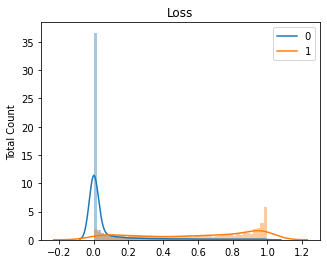

In [378]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
    sns.distplot(y_scores[y_eval==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')



In [379]:
confusion_matrix(y_eval,y_hat)

array([[21736,  1459],
       [  659,  1066]])

Text(0.5, 1.0, 'ROC curve')

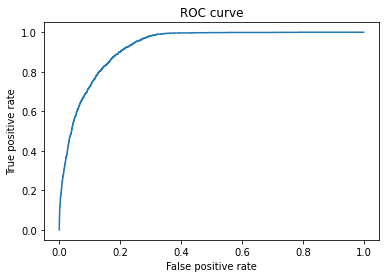

In [380]:
fpr, tpr, threshood = metrics.roc_curve(y_eval, y_scores, pos_label=1)
plt.plot(fpr, tpr, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [381]:
accuracy_score(y_eval,y_hat)

0.915008025682183

## Feature importance

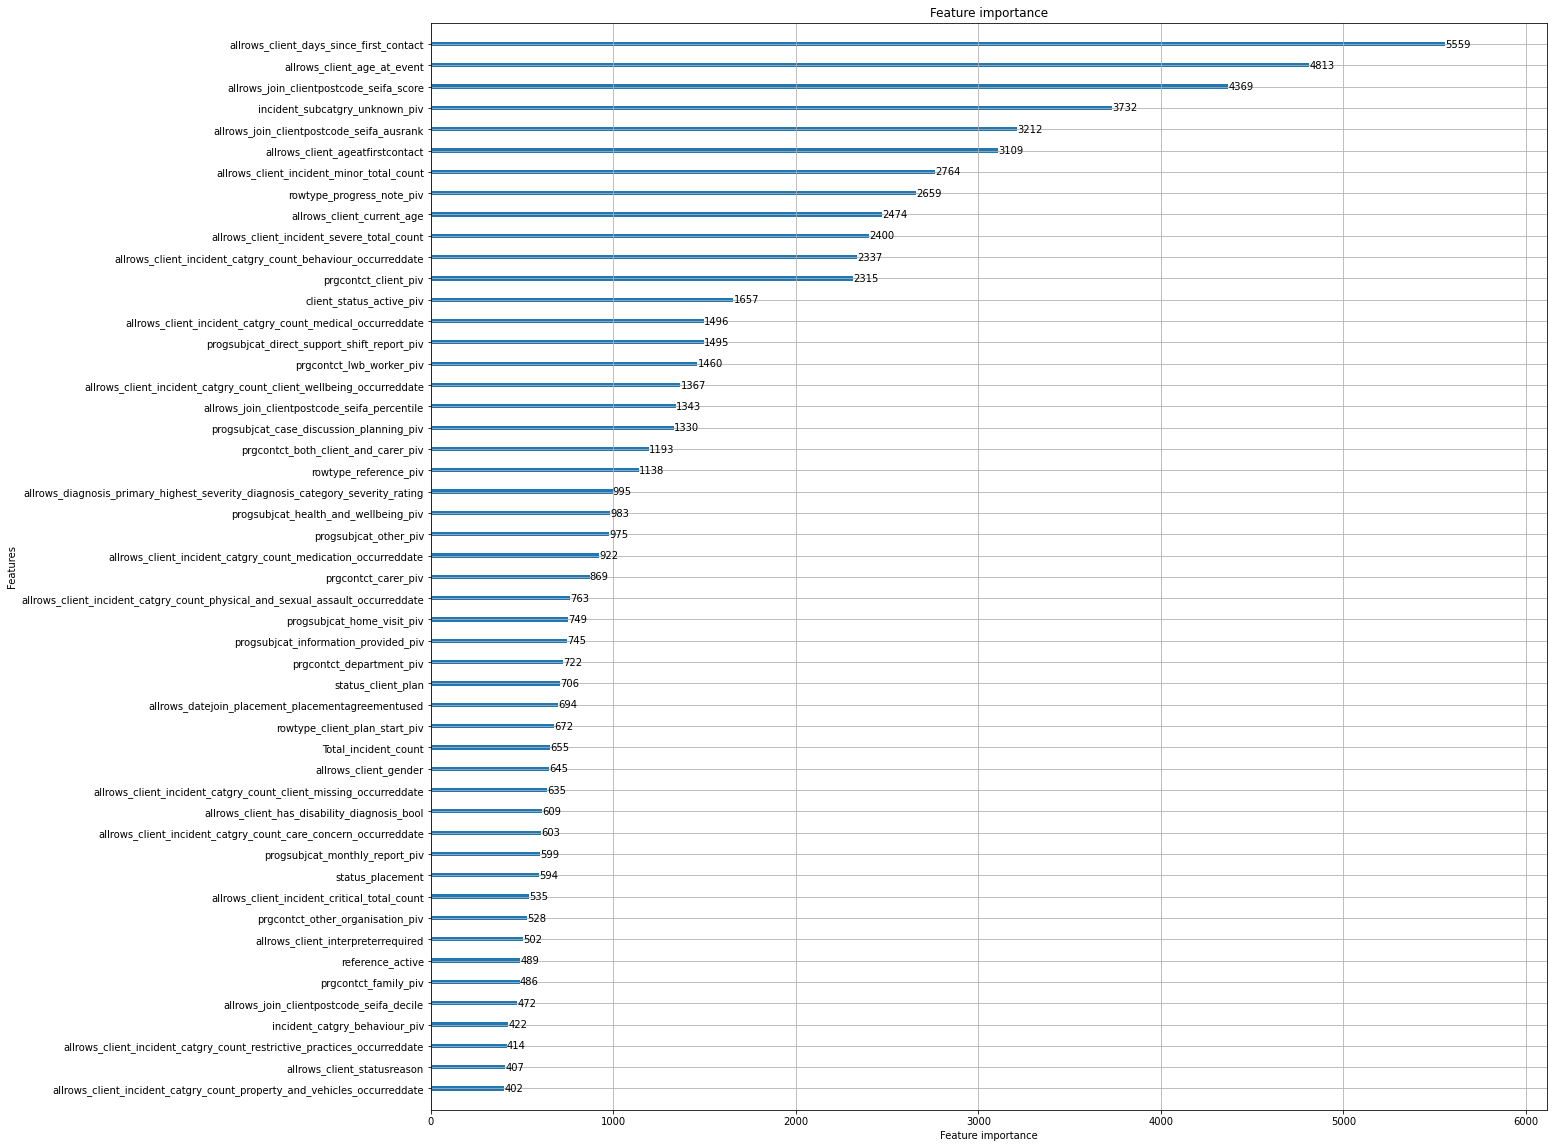

In [382]:
ax = lightgbm.plot_importance(model, figsize=(20,20),max_num_features=50)

<AxesSubplot:>

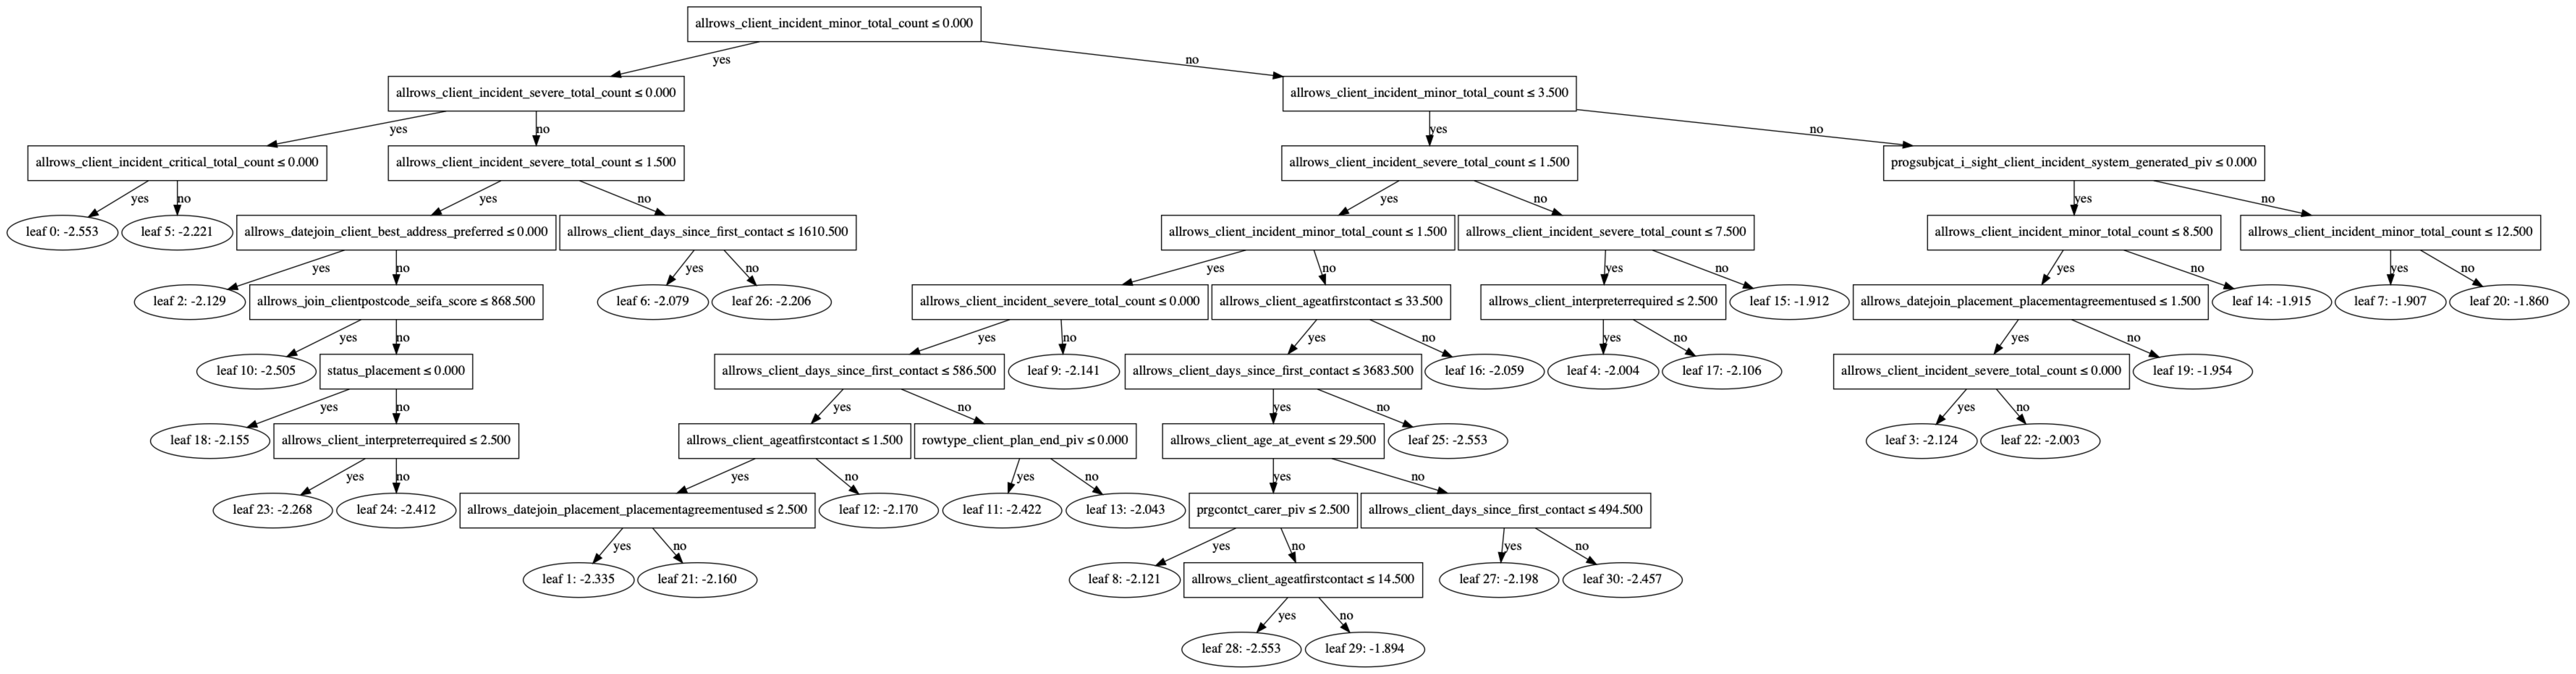

In [383]:
lightgbm.plot_tree(model,figsize=(100,100),orientation='vertical')

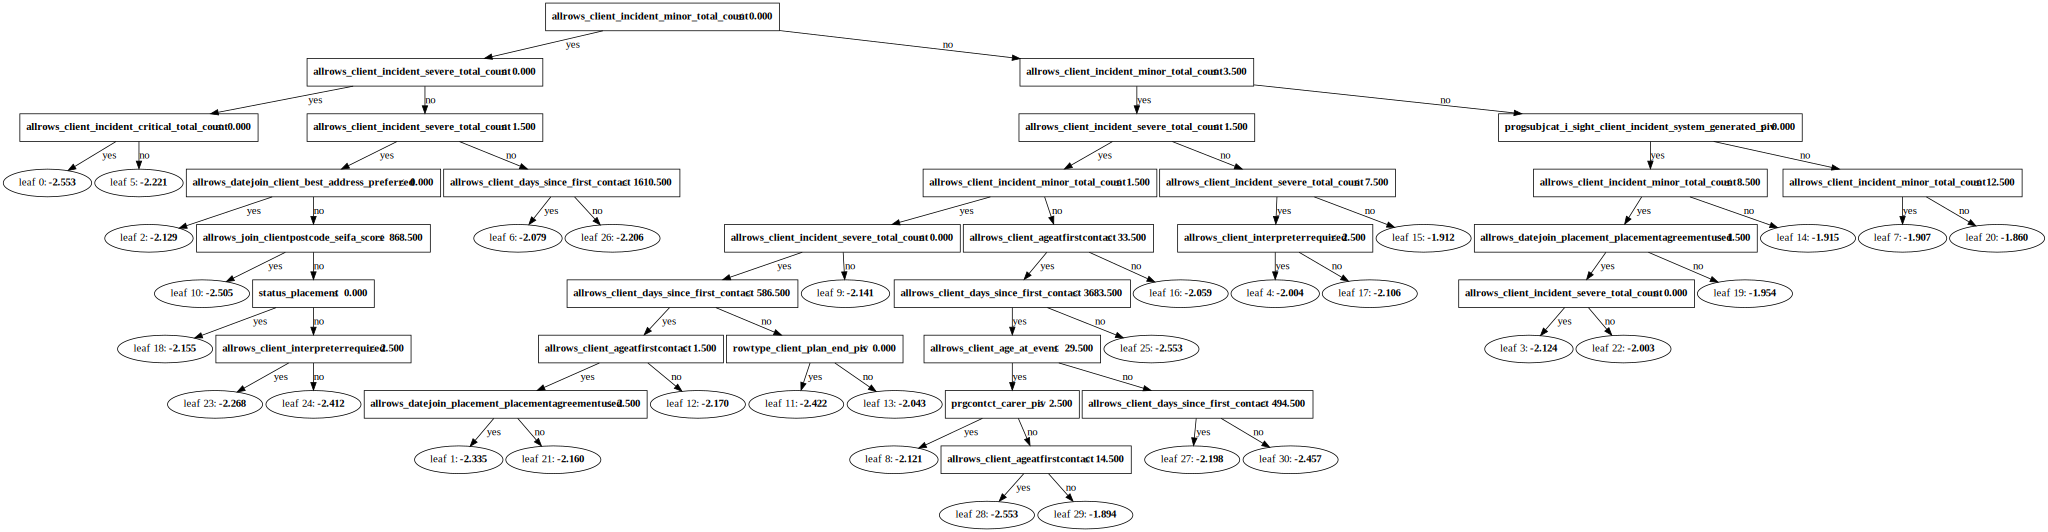

In [384]:
lightgbm.create_tree_digraph(model,orientation='vertical')

In [385]:
positive = sum(list(y_train))
print(positive)
negative = len(y_train) - positive
print(negative)



5605
68181


In [386]:
import math
def probability(leaf):
    p = math.exp(leaf)/(1+math.exp(leaf))
    return p

probability(-1.872)

0.1333104754333704

# Cross validation

In [26]:
model_cv = lightgbm.cv(parameters,
                       train_data,
                       num_boost_round=2000,return_cvbooster=True)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Curre

In [27]:
cv_result = model_cv["cvbooster"].predict(x_eval)

In [28]:
cv_result = np.array(cv_result)

#### Mean vote

In [29]:
y_hat = np.where(cv_result.mean(axis=0) < 0.5, 0, 1) 
f1_score(y_eval,y_hat)

0.5347732181425486